In [1]:
# Import required libraries
import os
import shutil
import re
import glob
import pandas as pd
from tqdm import tqdm
import random
from PIL import Image
import matplotlib.pyplot as plt

# Fruits-360 Dataset Preparation for YOLO Classification

This notebook processes the Fruits-360 dataset to create a YOLO-compatible classification dataset.
Instead of classifying specific varieties like "Apple Red 1", "Apple Red 2", etc., we'll group them into general categories like "apple".

## 1. Define Paths and Configuration

In [2]:
# Define paths - MODIFY THESE to match your system
base_dir = os.path.join("..", "datasets", "fruits")  # Path to the original fruits-360 dataset
output_dir = os.path.join("..", "datasets", "fruits_yolo")  # Where to save the processed dataset

# Create output directory
os.makedirs(output_dir, exist_ok=True)

## 2. Create Mapping from Specific Fruit Varieties to General Categories

In [3]:
def create_fruit_mapping(training_dir):
    """
    Create a mapping from specific fruit varieties to general categories.
    For example: 'Apple Red Delicious' -> 'apple'
    """
    fruit_mapping = {}
    
    # Common fruit categories and their patterns
    patterns = {
        'apple': r'^Apple\s.*',
        'banana': r'^Banana\s.*',
        'orange': r'^Orange\s.*',
        'pear': r'^Pear\s.*',
        'grape': r'^Grape\s.*',
        'kiwi': r'^Kiwi\s.*',
        'mango': r'^Mango\s.*',
        'peach': r'^Peach\s.*',
        'plum': r'^Plum\s.*',
        'strawberry': r'^Strawberry\s.*',
        'pineapple': r'^Pineapple\s.*',
        'cherry': r'^Cherry\s.*',
        'tomato': r'^Tomato\s.*',
        'watermelon': r'^Watermelon\s.*',
        "cactus fruit": r'^Cactus fruit\s.*'
        # Add more patterns as needed
    }
    
    # Get all fruit directories in the dataset
    fruit_dirs = []
    try:
        fruit_dirs = os.listdir(training_dir)
    except FileNotFoundError:
        print(f"Directory not found: {training_dir}")
        print("Please set the correct 'base_dir' path to your Fruits-360 dataset.")
        return {}
    
    # Map each fruit to its general category
    for fruit_dir in fruit_dirs:
        matched = False
        for general_name, pattern in patterns.items():
            if re.match(pattern, fruit_dir, re.IGNORECASE):
                fruit_mapping[fruit_dir] = general_name
                matched = True
                break
        
        if not matched:
            # If no pattern matches, use the first word as the general category
            general_name = fruit_dir.split()[0].lower()
            fruit_mapping[fruit_dir] = general_name
    
    return fruit_mapping

# Get the mapping
training_dir = os.path.join(base_dir, "Training")
fruit_mapping = create_fruit_mapping(training_dir)

# Display the mapping (first 10 items)
pd.DataFrame(list(fruit_mapping.items()), columns=['Original Name', 'General Category'])

,Original Name,General Category
0,Apple 10,apple
1,Apple 11,apple
2,Apple 12,apple
3,Apple 13,apple
4,Apple 14,apple
...,...,...
201,Tomato not Ripen 1,tomato
202,Walnut 1,walnut
203,Watermelon 1,watermelon
204,Zucchini 1,zucchini


## 3. Analyze the Distribution of General Categories

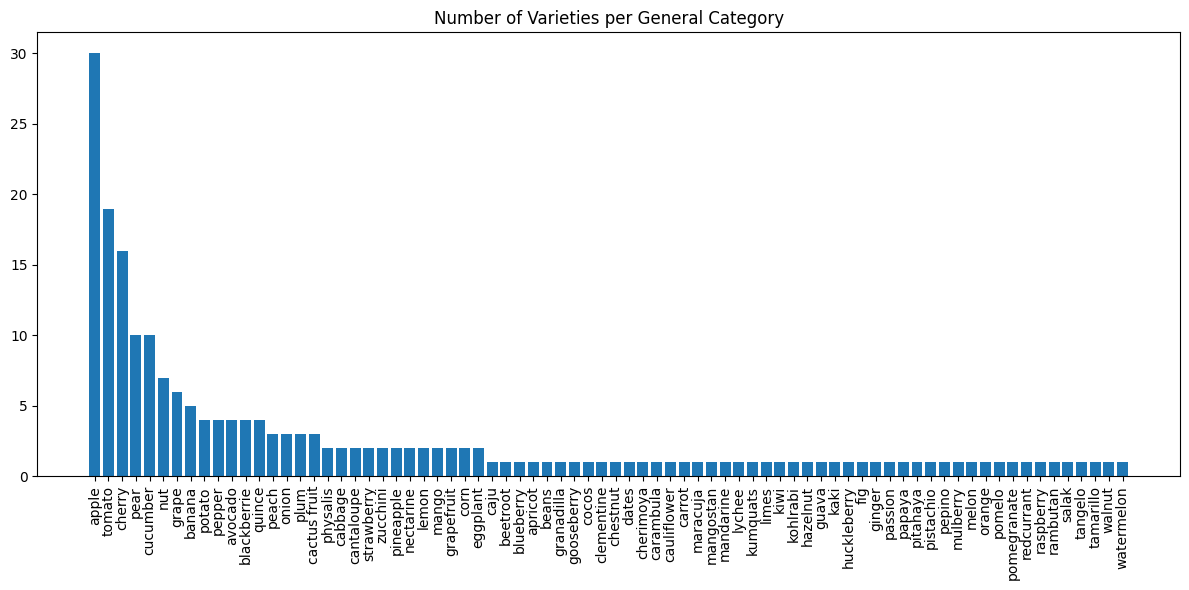

,General Category,Number of Varieties
0,apple,30
72,tomato,19
16,cherry,16
53,pear,10
21,cucumber,10
...,...,...
68,salak,1
71,tangelo,1
70,tamarillo,1
73,walnut,1


In [4]:
# Count the number of varieties per general category
category_counts = {}
for _, category in fruit_mapping.items():
    category_counts[category] = category_counts.get(category, 0) + 1

# Display as a DataFrame
category_df = pd.DataFrame(list(category_counts.items()), 
                          columns=['General Category', 'Number of Varieties'])
category_df = category_df.sort_values('Number of Varieties', ascending=False)

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.bar(category_df['General Category'], category_df['Number of Varieties'])
plt.xticks(rotation=90)
plt.title('Number of Varieties per General Category')
plt.tight_layout()
plt.show()

category_df

## 4. Create YOLO Classification Dataset Structure

In [5]:
def create_yolo_dataset(fruit_mapping, train_val_split=0.8):
    """
    Create a YOLO-compatible classification dataset following the official format:
    - One folder per class in train/ and val/ directories
    - Images placed directly in class folders
    
    Args:
        fruit_mapping: Dictionary mapping fruit varieties to general categories
        train_val_split: Ratio for train/validation split (default: 0.8)
    """
    # Create base directories
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    
    # Get all unique classes
    classes = sorted(list(set(fruit_mapping.values())))
    print(f"Found {len(classes)} unique fruit categories")
    
    # Create class directories
    for cls in classes:
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    
    # Process each fruit variety
    for fruit_variety, general_class in tqdm(fruit_mapping.items(), desc="Processing fruits"):
        # Get training images
        train_images_path = os.path.join(base_dir, "Training", fruit_variety)
        test_images_path = os.path.join(base_dir, "Test", fruit_variety)
        
        if not os.path.exists(train_images_path) or not os.path.exists(test_images_path):
            print(f"Warning: Path not found for {fruit_variety}")
            continue
        
        # Get all training images
        train_images = glob.glob(os.path.join(train_images_path, "*.jpg"))
        if not train_images:
            train_images = glob.glob(os.path.join(train_images_path, "*.png"))
        
        # Get all test images
        test_images = glob.glob(os.path.join(test_images_path, "*.jpg"))
        if not test_images:
            test_images = glob.glob(os.path.join(test_images_path, "*.png"))
        
        # Combine all images and shuffle
        all_images = train_images + test_images
        random.shuffle(all_images)
        
        # Split into train and validation sets
        split_idx = int(len(all_images) * train_val_split)
        train_set = all_images[:split_idx]
        val_set = all_images[split_idx:]
        
        # Process training set - copy images to the class folder
        for img_path in train_set:
            img_filename = os.path.basename(img_path)
            # Add a unique prefix to avoid potential filename conflicts
            dst_path = os.path.join(train_dir, general_class, f"{fruit_variety}_{img_filename}")
            shutil.copy(img_path, dst_path)
        
        # Process validation set - copy images to the class folder
        for img_path in val_set:
            img_filename = os.path.basename(img_path)
            # Add a unique prefix to avoid potential filename conflicts
            dst_path = os.path.join(val_dir, general_class, f"{fruit_variety}_{img_filename}")
            shutil.copy(img_path, dst_path)
    
    # Create data.yaml file for YOLO
    with open(os.path.join(output_dir, "data.yaml"), "w") as f:
        f.write(f"path: {output_dir}\n")
        f.write(f"train: train\n")
        f.write(f"val: val\n")
        f.write(f"nc: {len(classes)}\n")
        
        # Write names as a proper YAML list
        f.write("names:\n")
        for cls in classes:
            f.write(f"  - {cls}\n")
    
    return classes

# Execute the dataset creation if fruit_mapping is not empty
if fruit_mapping:
    classes = create_yolo_dataset(fruit_mapping)
    print(f"YOLO dataset created successfully with {len(classes)} general categories!")
    print(f"Classes: {classes}")
else:
    print("Dataset creation skipped. Please check the base_dir path.")

Found 76 unique fruit categories


Processing fruits: 100%|██████████| 206/206 [00:23<00:00,  8.85it/s]

YOLO dataset created successfully with 76 general categories!
Classes: ['apple', 'apricot', 'avocado', 'banana', 'beans', 'beetroot', 'blackberrie', 'blueberry', 'cabbage', 'cactus fruit', 'caju', 'cantaloupe', 'carambula', 'carrot', 'cauliflower', 'cherimoya', 'cherry', 'chestnut', 'clementine', 'cocos', 'corn', 'cucumber', 'dates', 'eggplant', 'fig', 'ginger', 'gooseberry', 'granadilla', 'grape', 'grapefruit', 'guava', 'hazelnut', 'huckleberry', 'kaki', 'kiwi', 'kohlrabi', 'kumquats', 'lemon', 'limes', 'lychee', 'mandarine', 'mango', 'mangostan', 'maracuja', 'melon', 'mulberry', 'nectarine', 'nut', 'onion', 'orange', 'papaya', 'passion', 'peach', 'pear', 'pepino', 'pepper', 'physalis', 'pineapple', 'pistachio', 'pitahaya', 'plum', 'pomegranate', 'pomelo', 'potato', 'quince', 'rambutan', 'raspberry', 'redcurrant', 'salak', 'strawberry', 'tamarillo', 'tangelo', 'tomato', 'walnut', 'watermelon', 'zucchini']


## 5. Verify the Created Dataset

Dataset Statistics:
  Total training images: 110856
  Total validation images: 27843


,Class,Training,Validation,Total
0,apple,17142,4302,21444
72,tomato,10928,2744,13672
16,cherry,9777,2453,12230
53,pear,5604,1409,7013
21,cucumber,4350,1091,5441
...,...,...,...,...
25,ginger,316,80,396
8,cabbage,310,79,389
4,beans,248,62,310
10,caju,240,61,301


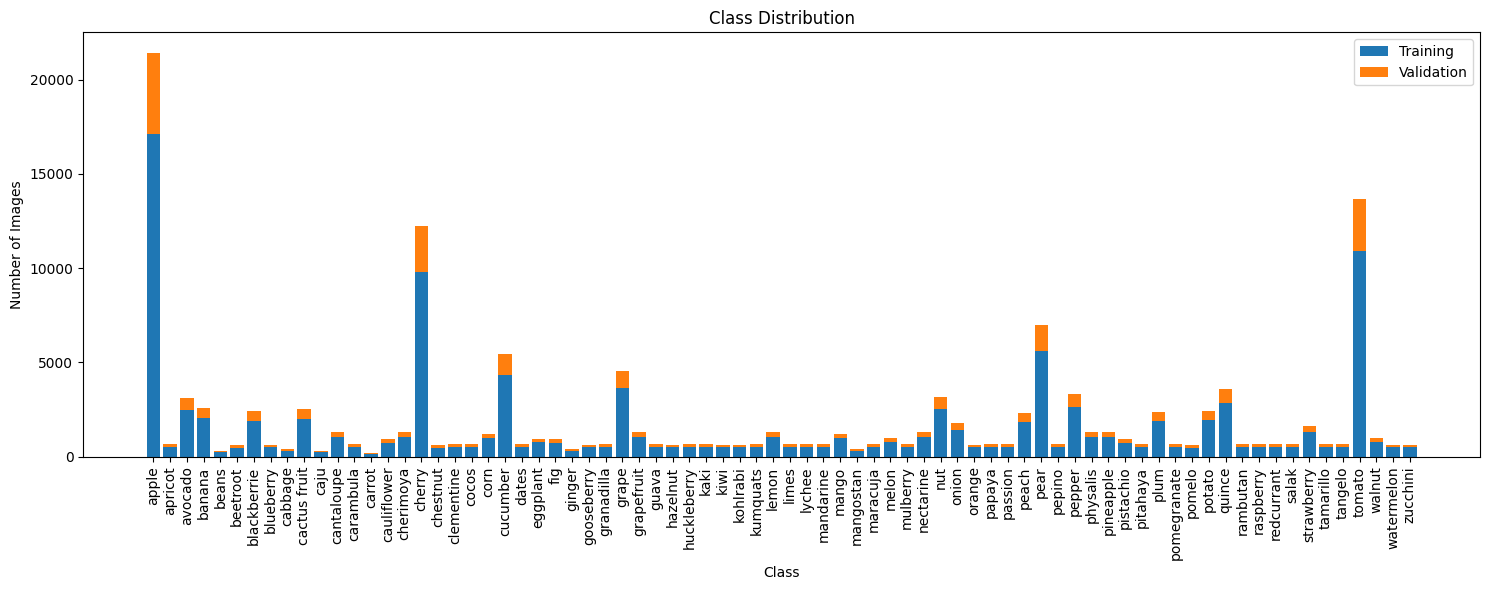

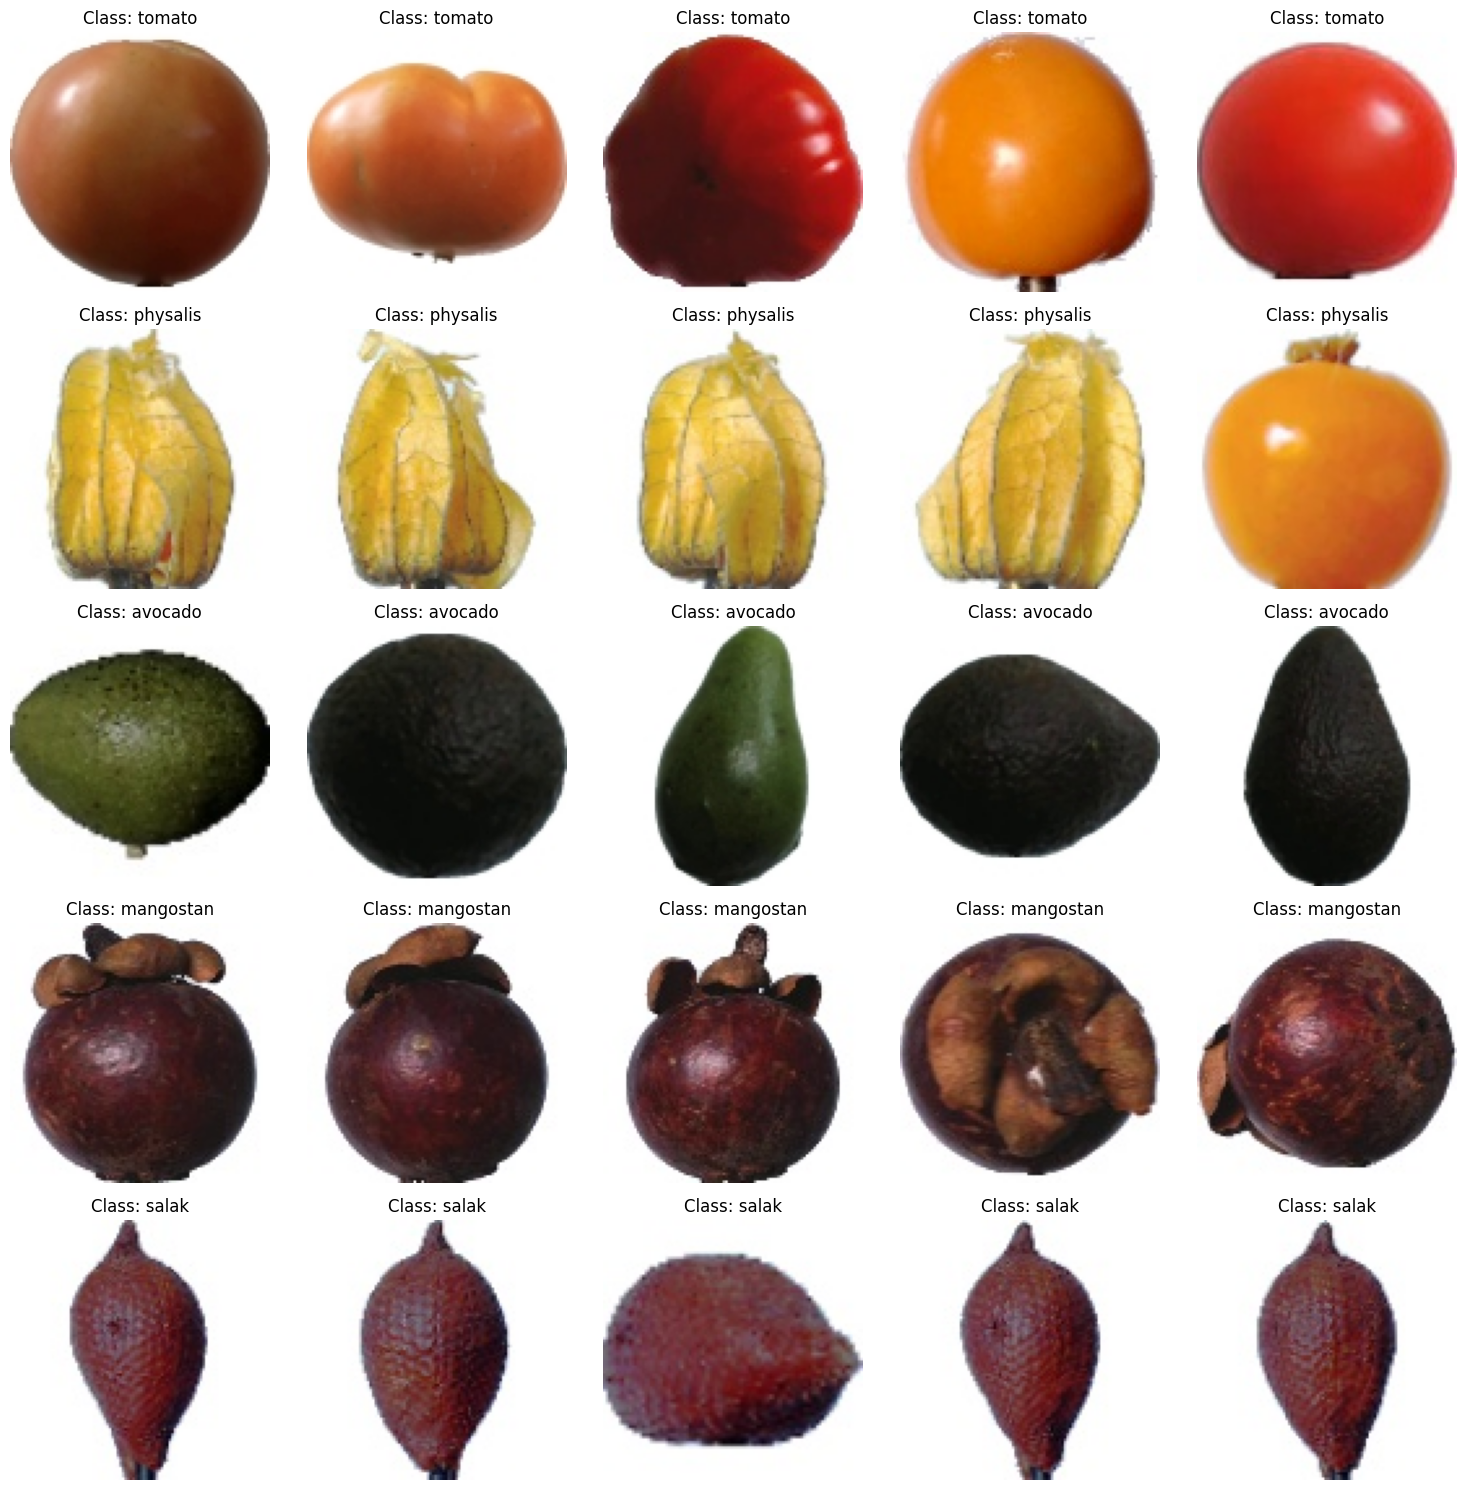

In [6]:
def verify_dataset():
    """Verify the created dataset structure and display a few examples"""
    train_dir = os.path.join(output_dir, "train")
    val_dir = os.path.join(output_dir, "val")
    
    # Check if directories exist
    if not os.path.exists(train_dir) or not os.path.exists(val_dir):
        print(f"Directories not found. Dataset creation may have failed.")
        return
    
    # Count files in each class directory
    class_counts = {'train': {}, 'val': {}}
    total_train = 0
    total_val = 0
    
    for cls in classes:
        train_class_dir = os.path.join(train_dir, cls)
        val_class_dir = os.path.join(val_dir, cls)
        
        if os.path.exists(train_class_dir):
            n_train = len([f for f in os.listdir(train_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
            class_counts['train'][cls] = n_train
            total_train += n_train
        
        if os.path.exists(val_class_dir):
            n_val = len([f for f in os.listdir(val_class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])
            class_counts['val'][cls] = n_val
            total_val += n_val
    
    print(f"Dataset Statistics:")
    print(f"  Total training images: {total_train}")
    print(f"  Total validation images: {total_val}")
    
    # Create DataFrame for class distribution
    df_data = []
    for cls in classes:
        df_data.append({
            'Class': cls,
            'Training': class_counts['train'].get(cls, 0),
            'Validation': class_counts['val'].get(cls, 0),
            'Total': class_counts['train'].get(cls, 0) + class_counts['val'].get(cls, 0)
        })
    
    df = pd.DataFrame(df_data)
    display(df.sort_values('Total', ascending=False))
    
    # Plot class distribution
    plt.figure(figsize=(15, 6))
    plt.bar(df['Class'], df['Training'], label='Training')
    plt.bar(df['Class'], df['Validation'], bottom=df['Training'], label='Validation')
    plt.xticks(rotation=90)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Display a few random examples from each class
    n_classes_to_show = min(5, len(classes))
    sample_classes = random.sample(classes, n_classes_to_show)
    
    plt.figure(figsize=(15, n_classes_to_show * 3))
    for i, cls in enumerate(sample_classes):
        cls_dir = os.path.join(train_dir, cls)
        if not os.path.exists(cls_dir):
            continue
            
        images = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if not images:
            continue
            
        samples = random.sample(images, min(5, len(images)))
        
        for j, img_file in enumerate(samples):
            img_path = os.path.join(cls_dir, img_file)
            img = Image.open(img_path)
            
            plt.subplot(n_classes_to_show, 5, i*5 + j + 1)
            plt.imshow(img)
            plt.title(f"Class: {cls}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run verification if dataset was created
if 'classes' in locals():
    verify_dataset()

## 6. Summary and Next Steps

The dataset is now ready for YOLO classification training with the official structure:

```
output_dir/
├── train/
│   ├── apple/       # All apple images
│   ├── banana/      # All banana images
│   └── ...          # Other fruit classes
├── val/
│   ├── apple/       # Validation apple images
│   ├── banana/      # Validation banana images
│   └── ...          # Other fruit classes
└── data.yaml        # Configuration for YOLO training
```

This organization:
1. Follows the official YOLO classification dataset structure
2. Uses directory names as class labels (no separate label files needed)
3. Makes it easy for the model to learn class features rather than directory structure
4. Is compatible with Ultralytics YOLO implementation

To use this dataset with YOLO:
1. Install YOLOv5, YOLOv8, or YOLOv11
2. Use the data.yaml file for training
3. Train your classification model with a command like:
   ```
   yolo classify train data=path/to/data.yaml model=yolov11n-cls.pt epochs=25
   ```